# Setup

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import json
from scipy.optimize import curve_fit
import scipy.io
import cloudvolume
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/efish_em/efish_em')

In [2]:
# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths
import AnalysisCode as efish

In [12]:
'''
conda install conda-forge::google-cloud-sdk

Then, launch jupyter lab 

In a code cell, run bash command <!gcloud auth login > (https://cloud.google.com/sdk/gcloud/reference/auth/login)
    a browser tab should open up

RESULT:
You are now logged in as [kperky@gmail.com].
Your current project is [lcht-goog-connectomics].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
'''
!gcloud auth login 

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=DJXvPVuentwXn1bRUkvuRWPk3IAilf&access_type=offline&code_challenge=HO3Vwr5CvjYziHOeJNP-Ek7OpGiQzrHRn1T3CaGtgYs&code_challenge_method=S256


You are now logged in as [kperky@gmail.com].
Your current project is [lcht-goog-connectomics].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


## Settings definitions

Whether you are converting from neuroglancer or creating a new reconstruction, the settings_dict parameters is needed to create CREST json files with correct formatting. 
- 'save_dir' : the directory where JSON files are saved 
- 'cred' and 'db_path' : specify the path to the agglomeration database file on your local computer. 

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = efish.import_settings(path_to_settings_json)

# Image Analysis

In [4]:
dirpath = Path('/Volumes/sawtell-locker/locker/ELL/scope/scope3/cropped/slide2sect1_L')
filelist = ['Results_nuclei_dapi.csv','Results_nuclei_gly.csv','Results_nuclei_gaba.csv','Results_nuclei_glu.csv']

In [30]:
df['Mean'].max()

2996.334

In [34]:
# Optional: add a label to identify the source file (e.g., 'dapi', 'gly', etc.)
labels = [f.stem.split('_')[-1] for f in map(Path, filelist)]

dfs = []
for file, label in zip(filelist, labels):
    df = pd.read_csv(dirpath / file)
    
    # # Rename the first column if it's unnamed and should be 'roi'
    # if df.columns[0].startswith('Unnamed'):
    df.rename(columns={df.columns[0]: 'roi'}, inplace=True)
    df['Mean_norm'] = df['Mean'] - df['Mean'].min()
    df['Mean_norm']=df['Mean_norm'].div(df['Mean_norm'].max(),axis=0)
    
    df['marker'] = label
    dfs.append(df)

# Combine all into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

In [32]:
combined_df

,roi,Area,Mean,Min,Max,Ch,Mean_norm,marker
0,1,32.718,971.796,134,2433,3,0.324328,dapi
1,2,36.040,1571.809,131,2866,3,0.524577,dapi
2,3,19.015,1042.734,329,2540,3,0.348003,dapi
3,4,25.460,2996.334,1118,5216,3,1.000000,dapi
4,5,14.774,2407.312,723,5287,3,0.803419,dapi
...,...,...,...,...,...,...,...,...
87,19,49.478,110.073,90,139,4,0.344349,glu
88,20,21.750,110.469,89,153,4,0.345588,glu
89,21,25.489,124.271,90,1625,4,0.388766,glu
90,22,74.921,121.649,93,642,4,0.380563,glu


<AxesSubplot:xlabel='roi', ylabel='Mean'>

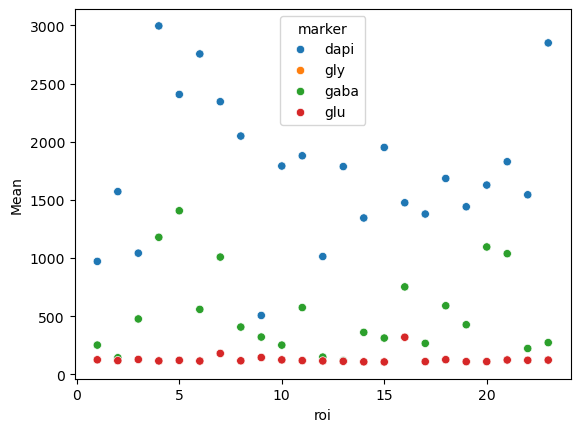

In [13]:
sns.scatterplot(data = combined_df, x='roi', y='Mean',hue='marker')

<AxesSubplot:xlabel='roi', ylabel='Mean_norm'>

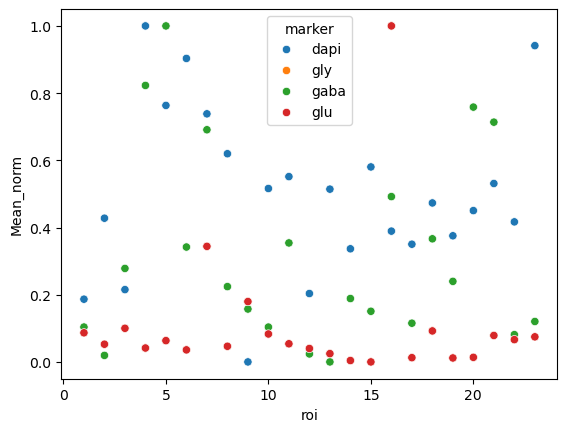

In [35]:
sns.scatterplot(data = combined_df, x='roi', y='Mean_norm',hue='marker')

<AxesSubplot:xlabel='Mean_glu', ylabel='Mean_gaba'>

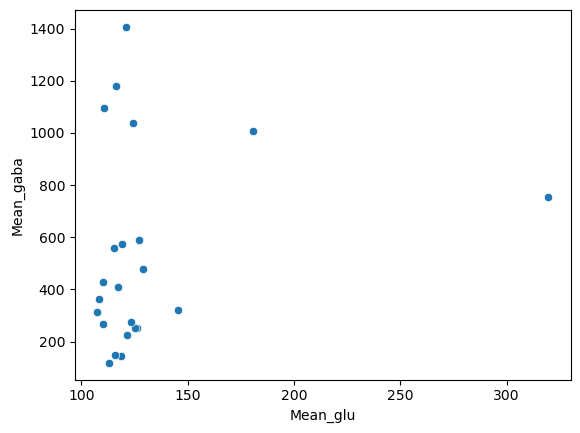

In [14]:
# Ensure columns of interest are present
# Keep only the columns you need: roi, marker, Mean
df_subset = combined_df[['roi', 'marker', 'Mean']].copy()

# Convert 'roi' to numeric in case it's a string
df_subset['roi'] = pd.to_numeric(df_subset['roi'], errors='coerce')

# Pivot the table: one row per roi, columns are marker names
reshaped_df = df_subset.pivot(index='roi', columns='marker', values='Mean')

# Optionally, rename columns to include 'Mean_' prefix
reshaped_df.columns = [f'Mean_{col}' for col in reshaped_df.columns]

# Reset index to make 'roi' a column again (optional)
reshaped_df = reshaped_df.reset_index()

sns.scatterplot(data = reshaped_df, x='Mean_glu', y='Mean_gaba')

In [17]:
reshaped_df.columns

Index(['roi', 'Mean_dapi', 'Mean_gaba', 'Mean_glu', 'Mean_gly'], dtype='object')

In [22]:
reshaped_df.loc[:,['Mean_dapi', 'Mean_gaba', 'Mean_glu', 'Mean_gly']]=reshaped_df[['Mean_dapi', 'Mean_gaba', 'Mean_glu', 'Mean_gly']].div(reshaped_df[['Mean_dapi', 'Mean_gaba', 'Mean_glu', 'Mean_gly']].sum(axis=1),axis=0)

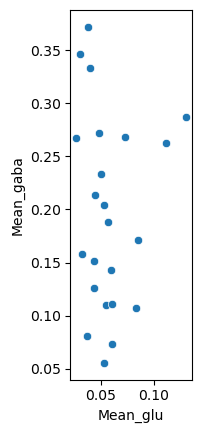

In [25]:
ax = sns.scatterplot(data = reshaped_df, x='Mean_glu', y='Mean_gaba')
ax.set_aspect('equal')

# Reconstruction Analysis

# Molecular layer fit

In [7]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

set([item['name'] for item in neuroglancer_data['layers'] if item['type']=='annotation'])

nl_ = 'molecular'
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
voxel_sizes = [16,16,30]

vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']] #[p['point'] for p in neuroglancer_layer['annotations']]#

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

# Perform curve fitting
popt, pcov = curve_fit(efish.func_planar_curve, (x_pts, z_pts), y_pts)

# Print optimized parameters
print(popt)


[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


# cell types for all files in directory

## from file

In [8]:
dirpath = Path(settings_dict['save_dir'])

df_type = pd.read_csv(dirpath / 'metadata/df_type_auto.csv')

## combine manual and auto type

In [539]:
nodefiles = efish.get_cell_filepaths(Path(settings_dict['save_dir'])) 

In [544]:
df_type = combo_type_manual_auto(nodefiles)

In [546]:
# df_type.to_csv(dirpath / 'metadata/df_type.csv')

# Get list of all cells in mg_network with main_seg in labeled regions

In [15]:
efish_cloudvolume = cloudvolume.CloudVolume('gs://fish-ell/roi450um_seg32fb16fb_220930', progress=False)

In [40]:
# Path to the folder containing the PNG images
folder_path = Path("/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/rnascope_compare")

## import actual coords

soma labeling within bounding box x: [] and z: []
No inclusion/exclusion planes accounted for yet
16nm resolution EM


In [90]:
mat = scipy.io.loadmat(folder_path / 'actual_coords.mat')

# Assuming your .mat file has a variable named 'data'
# containing the data you want to import into a dataframe.
# Replace 'data' with the actual variable name if it's different.

data = mat['actual_coords']  # Access the data from the loaded .mat file

# Create a pandas DataFrame from the data.
df_segments = pd.DataFrame(data,columns=('x','y','z'),index=range(1,len(data)+1))

# Now you can work with the DataFrame 'df'
print(df_segments.head())
print(df_segments.shape)

       x      y     z
1      0      0     0
2  16539  18808  1796
3  17000  18467  1686
4  17341  18288  1677
5  17266  18197  1799
(146, 3)


In [91]:
df_segments.dropna(inplace=True)
df_segments = df_segments.iloc[1:].copy(deep=True)

In [92]:
dirpath = Path(settings_dict['save_dir'])
base_segments = efish.get_base_segments_dict(Path(dirpath))

In [93]:
with tqdm(total=len(df_segments)) as pbar:
    for i,r in df_segments.iterrows():
        pbar.update(1)

        segid_to_find = int(efish_cloudvolume[[int(r['x']), int(r['y']), int(r['z'])]][0][0][0][0])
        
        df_segments.loc[i,'segment']= segid_to_find

        cell_id = [k.split('_')[2] for k,v in base_segments.items() if str(segid_to_find) in v]
        # print(cell_id)
        if cell_id == []:
            cell_id = np.NaN
            cell_type = 'none'
        elif cell_id != []:
            if len(cell_id)>1:
                print(f'{len(cell_id)} cells match: {cell_id}')
            if len(cell_id)==1:
                cell_id = cell_id[0]
                # print(cell_id)
                # print(df_type[df_type['id'].isin([cell_id])]['cell_type'])
                cell_type = df_type[df_type['id'].isin([int(cell_id)])]['cell_type'].values[0]
            
        # print(i,segid_to_find,cell_id)
    
    # enter cell_id in new column (empty or NaN if none)
        df_segments.loc[i,'cell_id'] = cell_id
        df_segments.loc[i,'cell_type']=cell_type
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:46<00:00,  3.13it/s]


In [94]:
df_segments['segment'] = df_segments['segment'].astype(int)

# Create new reconstruction for missing cells

If segment=0, use 'fix cell_id infor for missing segments'

In [119]:
df_segments[df_segments['cell_type'].isin(['none']) & (df_segments['segment']!=0)] 

,Unnamed: 0,x,y,z,segment,cell_id,cell_type


In [76]:
segment_id = '298244911'#     283375247
crest = ecrest(settings_dict,segment_id = segment_id, launch_viewer=True)

crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs
print(crest.get_ctype('manual'))

### check for duplicates in working directories

Creating base segment graph for cell 298244911 Cell Reconstruction
all base locations for 2520 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 298244911. No file saved yet -- save manually.
updating viewer status message: Current Base Segment Counts: unknown: 2520, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0
[]


In [77]:
# print(f'this file is: {cell_filepaths[cell_id].name}')
print('')
# actually check for duplicates of current reconstruction with base segments dictionary
# to save time, this line can be run alone after initializing base_segments dictionary above
print('overlap in main network:'); df = crest.check_duplicates(base_segments); display(df)
# print('overlap in Rachel folder:'); df = crest.check_duplicates(base_segments_todo1); display(df)
# print('overlap in todo folder:'); df = crest.check_duplicates(base_segments_todo2); display(df)


overlap in main network:


,self,dups,overlap-percent,number_seg_lap
1521,298244911,cell_graph_298228381__2023-07-12 12.54.04.json,0.884892,2460.0
2559,298244911,cell_graph_388667843__2025-01-14 17.01.07.json,0.007067,4.0
4193,298244911,cell_graph_49841518__2024-03-20 12.42.07.json,0.002198,6.0


### define cell type and save

In [475]:
cell_type = 'sgx2' # Assign the cell type then run the code cell

crest.define_ctype(cell_type,"manual")

In [58]:
crest.save_cell_graph()

Saved cell 304064921 reconstruction locally at 2025-04-25 14.40.17



## EDIT reconstruction from file

If you wanted to edit a reconstruction from an existing file, you would use the following code block to launch.

Specify the cell_id and the path to the directory that cell is in. 

> NOTE: You can also directly copy paste the full filepath to the cell you want to open and pass it to the ```filepath``` flag.  
In that case, the only code you need is crest = ecrest(settings_dict,filepath= [*paste filepath here*], launch_viewer=True)

To change the save location you can specify the ```directory_path``` flag in the ```save_cell_graph()``` module

> To overwrite a file (not recommended), specify ```(directory_path = cell_filepaths[cell_id].parent, file_name = cell_filepaths[cell_id].name)```

In [48]:
directory_path = Path(settings_dict['save_dir'])#/'Rachel' # specify the directory path

cell_filepaths = get_cell_filepaths(directory_path) # gets filepaths for all cells in a directory

In [78]:
cell_id = '298228381' # specify the cell id

crest = ecrest(settings_dict,filepath= cell_filepaths[cell_id], launch_viewer=True)
# crest = ecrest(settings_dict,filepath= directory_path.parent/ 'cell_graph_221592066__2023-10-12 09.10.56.json', launch_viewer=True)
print(cell_filepaths[cell_id])
crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

updating viewer status message: Current Base Segment Counts: unknown: 1573, axon: 147, basal dendrite: 134, apical dendrite: 926, dendrite: 0, multiple: 0
/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_298228381__2023-07-12 12.54.04.json


Map({"dblclick0": "add-or-remove-seg", "alt+mousedown2": "mark-branch-in-colour", "shift+mousedown2": "change-anchor-seg", "alt+mousedown0": "add-or-remove-seg"})

In [321]:
crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs

In [75]:
t = crest.get_ctype('manual'); print(f'manual type: {t}')
t = crest.get_ctype('auto'); print(f'auto type: {t}')

manual type: sgx2
auto type: []


## fix cell_id info for missing segments 

this is when the location of the VAST segment does not correspond to any base_seg


In [113]:
df_segments[df_segments['cell_type'].isin(['none']) | (df_segments['segment']==0)] 

,x,y,z,segment,cell_id,cell_type
77,18210,18026,1678,0,304064921,tsd
117,19606,16634,1547,0,300673220,sgx2
145,15416,15880,1635,0,298228381,mg1


In [107]:
df_segments = df_segments.copy(deep=True)

In [112]:
df_segments.loc[77,'cell_id'] = 304064921
df_segments.loc[77,'cell_type'] = df_type[df_type['id'].isin([int(304064921)])]['cell_type'].values[0]
df_segments.loc[117,'cell_id'] = 300673220
df_segments.loc[117,'cell_type'] = df_type[df_type['id'].isin([int(300673220)])]['cell_type'].values[0]
df_segments.loc[145,'cell_id'] = 298228381
df_segments.loc[145,'cell_type'] = df_type[df_type['id'].isin([int(298228381)])]['cell_type'].values[0]

In [114]:
df_segments.to_csv(folder_path / 'df_segments.csv')

# df_segments from file

In [135]:
df_segments = pd.read_csv(folder_path / 'df_segments.csv') 

In [138]:
df_segments.head()

,Unnamed: 0,x,y,z,segment,cell_id,cell_type,y_adj
0,2,264.624,300.928,53.88,392163654,306291045,h,46.019922
1,3,272.000,295.472,50.58,306306823,306306044,h,40.910453
2,4,277.456,292.608,50.31,305177235,305176846,smpl,38.042250
3,5,276.256,291.152,53.97,391049363,391049801,smpl,36.175787
4,6,267.344,291.472,55.35,391034236,391034186,sgx1,36.401528


In [125]:
df_segments.groupby('cell_type')['cell_id'].count()

cell_type
glia     2
grc     12
h        9
lf       3
lg       4
mg1      6
mg2      3
mli      7
sg1     31
sg2      9
sgx1    11
sgx2     5
smpl    26
tsd      6
uk      11
Name: cell_id, dtype: int64

# adjust y position

In [137]:
df_segments['y'] = df_segments['y'].multiply(16).divide(1000)
df_segments['x'] = df_segments['x'].multiply(16).divide(1000)
df_segments['z'] = df_segments['z'].multiply(30).divide(1000)

y_adj_col = []
for i,r in df_segments.iterrows():
    # print(i,r)
    # break
    yoffset = efish.func_planar_curve((r['x']*1000, r['z']*1000), *popt)
    # print(yoffset)
    y_adj = r['y'] - (yoffset/1000)
    y_adj_col.append(y_adj)

df_segments.loc[:,'y_adj']=y_adj_col


# Color Palette

In [12]:
cell_colors = efish.color_palette()

In [128]:
cell_cat_colors = {
    'smpl':'#ffccff',#'#B2D732',
    'h':'#FB9902',#'#B2D732',
    'grc':'#8601AF',
    'mli':'#999999',
    'mg1':'#66B032',
    'mg2':'#66B032',
    'sg1':'#B2D732',
    'sg2':'#B2D732',
    'sgx1':'#B2D732',
    'sgx2':'#B2D732',
    'lg':'#FE2712',
    'lf':'#FE2712',
    'tsd':'#FEFE33',
    'uk':'#ffffff',
    'none':'#000000',
    'glia':'#ffffff',
    'glu':'#ff0000',
    'gaba':'#00ff00',
    'other':'#666666'
}

# Plot soma locations by cell category

In [123]:
mask = (df_segments['cell_type']=='tsd') #& (df_segments['segment']==0)
df_segments[mask]['cell_id'].values

array([391066572, 307377189, 305130656, 304064921, 305208703, 306181538])

# categorize cell types

In [126]:

# Function to categorize cell types
def categorize_cell_type(cell_type):
    if cell_type in glu_types:
        return 'glu'
    elif cell_type in gaba_types:
        return 'gaba'
    else:
        return 'other'  # Use 'other' for any types not categorized



0 not yet identified out of 145 total


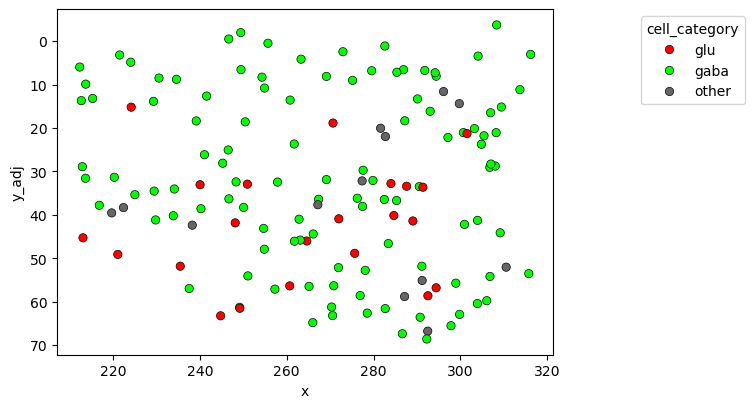

In [139]:

glu_types = ['lg', 'lf', 'tsd', 'h']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_category',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

0 not yet identified out of 145 total


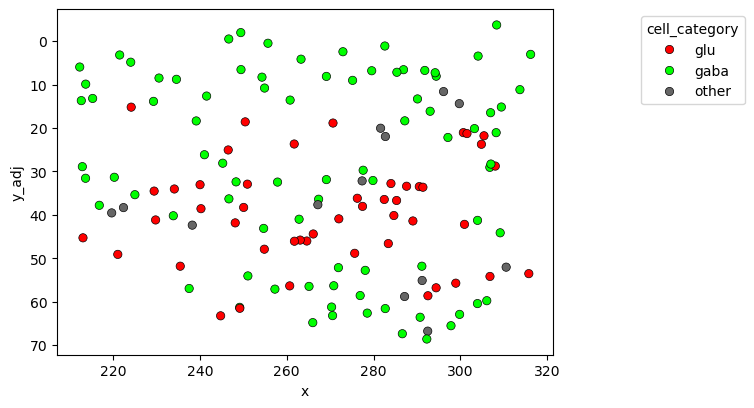

In [140]:

glu_types = ['lg', 'lf', 'tsd', 'h','smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_category',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

0 not yet identified out of 145 total


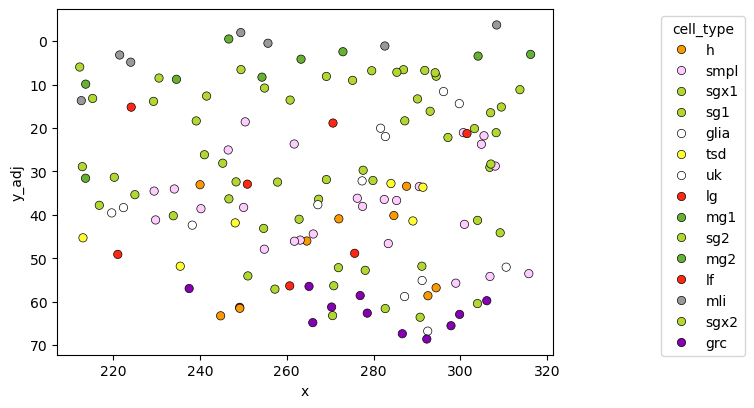

In [141]:
mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

0 not yet identified out of 145 total


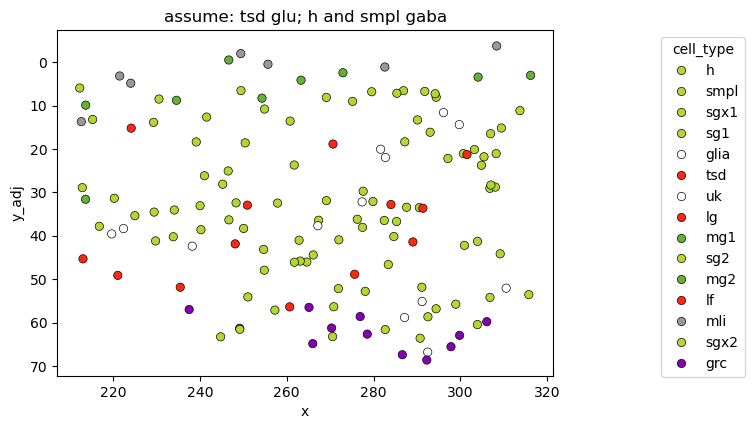

In [142]:
cell_cat_colors['h'] = '#B2D732' #green
cell_cat_colors['tsd'] = '#FE2712' #red
cell_cat_colors['smpl'] = '#B2D732'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

ax.set_title('assume: tsd glu; h and smpl gaba');

0 not yet identified out of 145 total


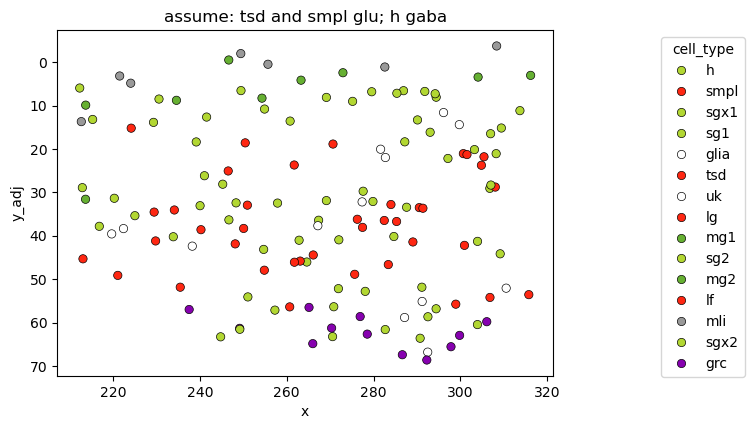

In [143]:
cell_cat_colors['h'] = '#B2D732' #green
cell_cat_colors['tsd'] = '#FE2712' #red
cell_cat_colors['smpl'] = '#FE2712'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title('assume: tsd and smpl glu; h gaba');

0 not yet identified out of 145 total


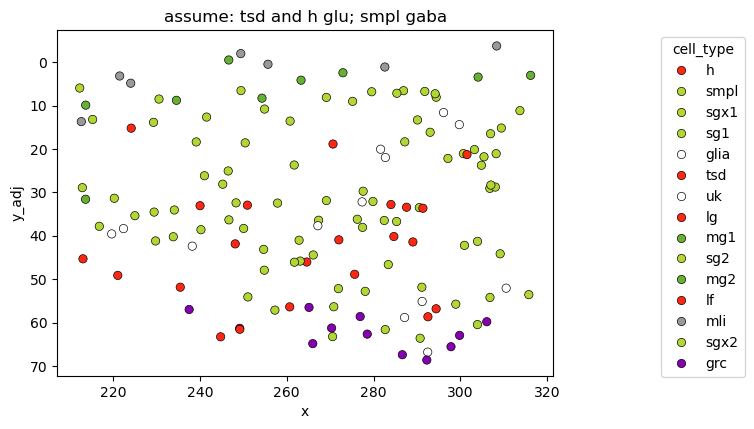

In [144]:
cell_cat_colors['h'] = '#FE2712' #red
cell_cat_colors['tsd'] = '#FE2712'
cell_cat_colors['smpl'] = '#B2D732' #green

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title('assume: tsd and h glu; smpl gaba');

0 not yet identified out of 145 total


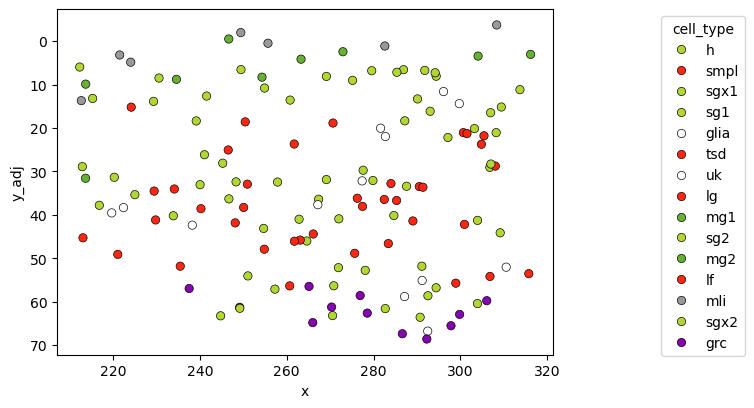

In [145]:
cell_cat_colors['h'] = '#B2D732'
cell_cat_colors['tsd'] = '#FE2712'
cell_cat_colors['smpl'] = '#FE2712'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

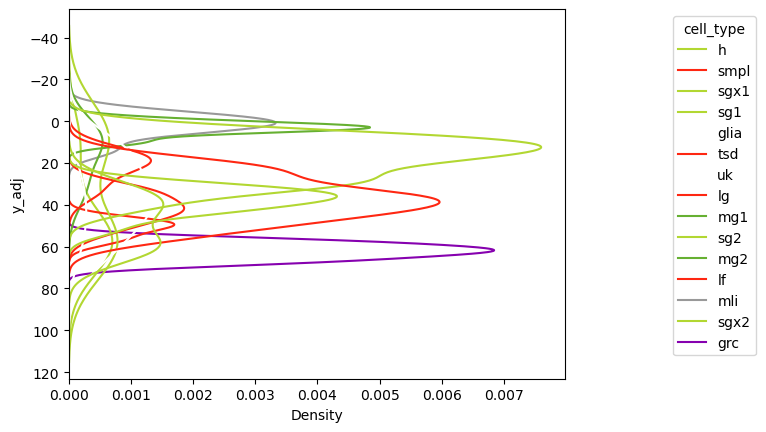

In [146]:

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_type',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

Text(0, 0.5, 'gaba (green) and glu (red) count')

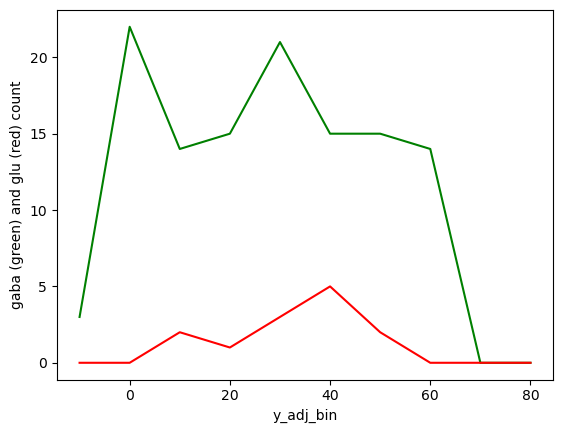

In [147]:

glu_types = ['lg', 'lf', 'tsd']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','h', 'smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

# Define bins for y_adj
bins = np.arange(-10, 100, 10)  
bin_labels = [f'Bin {i+1}' for i in range(len(bins)-1)]

# Cut y_adj into bins
df_segments['y_adj_bin'] = pd.cut(df_segments['y_adj'], bins=bins, labels=bins[0:-1])#,observed=False)

# Count the number of glu and gaba neurons in each bin
bin_counts = df_segments.groupby(['y_adj_bin', 'cell_category']).size().unstack(fill_value=0)

# Calculate the ratio of glu to gaba neurons
bin_counts['ratio'] = bin_counts['gaba'] / bin_counts['glu'].replace(0, np.nan)  # Replace 0 to avoid division by zero

hfig,ax = plt.subplots(1)
sns.lineplot(ax=ax,data=bin_counts.reset_index(),y='gaba',x='y_adj_bin',color='green')
sns.lineplot(ax=ax,data=bin_counts.reset_index(),y='glu',x='y_adj_bin',color='red')

ax.set_ylabel('gaba (green) and glu (red) count')

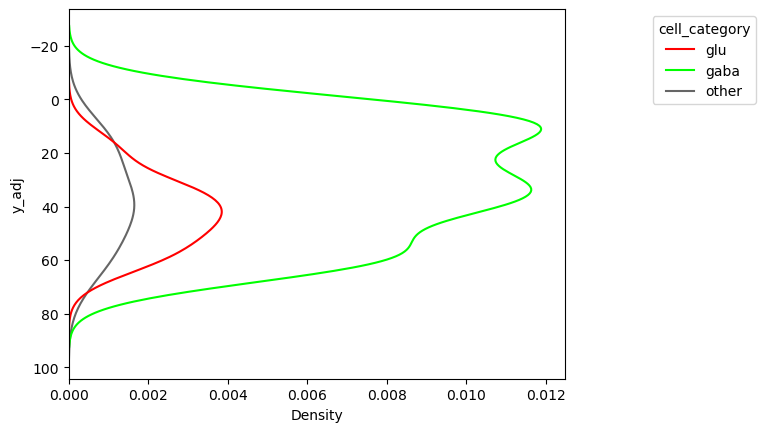

In [148]:

glu_types = ['lg', 'lf', 'tsd', 'h']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

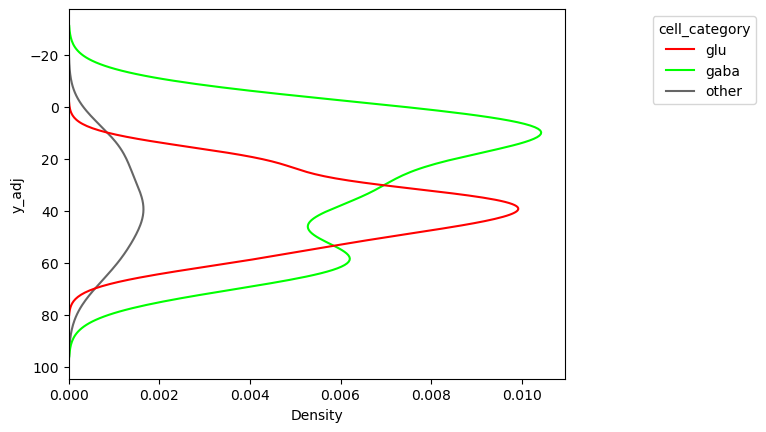

In [149]:

glu_types = ['lg', 'lf', 'tsd', 'h','smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

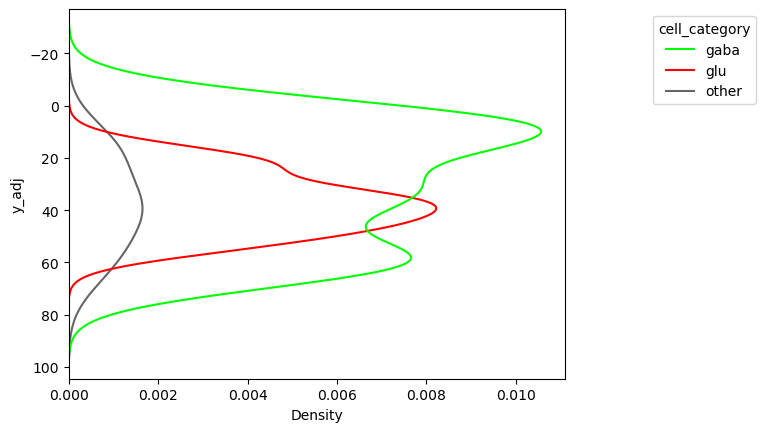

In [150]:

glu_types = ['lg', 'lf', 'tsd', 'smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','h']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));